## Benchmark 5: Oneshot naive model structured bootstrap resampling
Ok, so, I talked about the rationale and set-up for this at length in notebooks 08 & 09. Let's give it a test. Success criteria here is that our observed public leader score of ~1.09 for the naive 'carry-forward' model should not have a vanishingly small probability of coming from this dataset using this resampling procedure. If the SMAPE score distribution generated by this sampling procedure with the naive model is consistent with the observed public leaderboard score for the same model, we can declare victory and move on the better models and better data.
1. [Abbreviations & definitions](#abbrevations_definitions)
2. [Load & inspect](#load_inspect)

<a name="abbreviations_definitions"></a>
### 1. Abbreviations & definitions
+ MBD: microbusiness density
+ MBC: microbusiness count
+ OLS: ordinary least squares
+ Model order: number of past timepoints used as input data for model training
+ Origin (forecast origin): last known point in the input data
+ Horizon (forecast horizon): number of future data points predicted by the model
+ SMAPE: Symmetric mean absolute percentage error

<a name="load_inspect"></a>
### 2. Load & inspect

In [1]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf
#import functions.data_manipulation_functions as data_funcs

import statistics
import numpy as np
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt
from statistics import NormalDist

print(f'Python: {sys.version}')
print()
print(f'Numpy {np.__version__}')
print(f'Pandas {pd.__version__}')

Python: 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]

Numpy 1.23.5
Pandas 1.4.3


In [2]:
# Load parsed data
block_size = 8

output_file = f'{conf.DATA_PATH}/parsed_data/structured_bootstrap_blocksize{block_size}.npy'
timepoints = np.load(output_file)

print(f'Timepoints shape: {timepoints.shape}')
print()
print('Column types:')

for column in timepoints[0,0,0,0:]:
    print(f'\t{type(column)}')

print()
print(f'Example block:\n{timepoints[0,0,0:,]}')

Timepoints shape: (31, 3135, 8, 5)

Column types:
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>

Example block:
[[1.0010000e+03 1.5646176e+18 3.0076818e+00 1.2490000e+03 0.0000000e+00]
 [1.0010000e+03 1.5672960e+18 2.8848701e+00 1.1980000e+03 1.0000000e+00]
 [1.0010000e+03 1.5698880e+18 3.0558431e+00 1.2690000e+03 2.0000000e+00]
 [1.0010000e+03 1.5725664e+18 2.9932332e+00 1.2430000e+03 3.0000000e+00]
 [1.0010000e+03 1.5751584e+18 2.9932332e+00 1.2430000e+03 4.0000000e+00]
 [1.0010000e+03 1.5778368e+18 2.9690900e+00 1.2420000e+03 5.0000000e+00]
 [1.0010000e+03 1.5805152e+18 2.9093256e+00 1.2170000e+03 6.0000000e+00]
 [1.0010000e+03 1.5830208e+18 2.9332314e+00 1.2270000e+03 7.0000000e+00]]


OK this, numpy array is structured as follows:
+ **First dimension**: timepoints: left-edge anchored with respect to the timeseries. Each element contains the timeseries blocks for each county.
+ **Second dimension**: counties: each element is the timeseries block for that county.
+ **Third dimension**: rows: timeseries for block, starting from the left edge of the timepoint and running forward by bin_num timepoints.
+ **Fourth dimension**: columns: *cfips, first_day_of_month, microbusiness_density, active*, all floats.

Let's start by defining some helper functions so that we can easily score multiple samples.

In [3]:
num_samples = 3000
sample_size = 300 # set to string 'all' to include all data from timepoint in sample
model_order = 1

Model order is not a parameter of the naive model, since we are just going to carry forward the last MBD value. But, I want to build it in for the future.

In [4]:
def sample_parsed_data(timepoints, sample_size):
    '''Generates a random sample of sample_size from a random timepoint'''

    # Initialize random seed to make sure that output is differently random each call
    np.random.seed()

    # Pick random timepoint
    random_timepoint_index = np.random.choice(timepoints.shape[0], 1)
    timepoint = timepoints[random_timepoint_index][0]

    #print(f'Timepoint shape: {timepoint.shape}')

    if sample_size == 'all':
        return timepoint

    # Pick n unique random county indexes to include in the sample
    random_county_indices = np.random.choice(timepoint.shape[0], sample_size, replace=False)

    # Use random indices to extract sample from timepoint
    sample = timepoint[random_county_indices]

    return sample

In [5]:
def two_point_smape(actual, forecast):

    # If SMAPE denominator is zero set SMAPE to zero
    if actual == 0 and forecast == 0:
        return 0

    # Calculate smape for forecast
    smape = abs(forecast - actual) / ((abs(actual) + abs(forecast)) / 2)
    
    return smape

In [6]:
def naive_model_smape_score(sample, model_order):
    '''Takes a sample of blocks and gets smape values for each'''

    # Holder for SMAPE values
    smape_values = []

    for block_num in range(sample.shape[0]):

        # Get the forecasted value - last value in the model order (input) range
        forecast_value = sample[block_num, (model_order - 1), 2]

        # Get the true value
        actual_value = sample[block_num, model_order, 2]

        # Get and collect SMAPE value for this forecast
        smape_value = two_point_smape(actual_value, forecast_value)
        smape_values.append(smape_value)

        #print(f'Forecast: {forecast_value}, actual value: {actual_value}, SMAPE score: {smape_value}')

    smape_score = (100/len(smape_values)) * sum(smape_values)

    return smape_score

In [7]:
def bootstrap_smape_score(timepoints, num_samples, sample_size, model_order):

    smape_scores = []

    for i in range(num_samples):
        sample = sample_parsed_data(timepoints, sample_size)
        smape_score = naive_model_smape_score(sample, model_order)

        smape_scores.append(smape_score)

    return smape_scores

In [8]:
smape_scores = bootstrap_smape_score(timepoints, num_samples, sample_size, model_order)

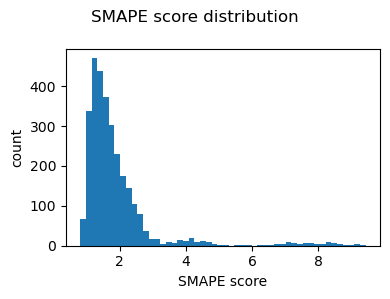

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

ax.hist(smape_scores, bins=50)
ax.set_xlabel('SMAPE score')
ax.set_ylabel('count')

plt.suptitle(f'SMAPE score distribution')
plt.tight_layout()

In [10]:
smape_mean = statistics.mean(smape_scores)
smape_std = statistics.pstdev(smape_scores)

print(f'Mean: {smape_mean}')
print(f'Standard deviation: {smape_std}')

leaderboard_score_probability = NormalDist(mu=smape_mean, sigma=smape_std).cdf(1.0936)
print(f'Probability of SMAPE <= 1.0936: {leaderboard_score_probability}')

Mean: 1.9142256578494703
Standard deviation: 1.258393197403687
Probability of SMAPE <= 1.0936: 0.25716129556624745


OK, good. I think we are happy. The SMAPE score distribution no longer looks normal at all, but I think this is because before we were plotting it as a smoothed density plot. now we can see that the scores pile up at values > 2.0, but have a very long tail to higher numbers. I think this is those pesky anomalies again. Good news is that we have about a 1 in 4 chance of drawing a sample which matches or beats the public leaderboard score with this model. That's probably not exactly accurate due to the skew of this distribution away from normal. But it does confirm that the probability is no unreasonably small - before we were getting anywhere from zero to on the order of 10<sup>-10</sup>. This means that now we can have some hope of optimizing for leaderboard position - improving our internal benchmark scores should improve our actual public leaderboard score.

Let's move on to some more advanced models.